In [224]:
def regression_model_setup_nail():
  class EfficientNet9ChannelsModel(nn.Module):
        def __init__(self, pretrained=True):
            super(EfficientNet9ChannelsModel, self).__init__()
            self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

            self.efficientnet.features[0][0] = nn.Conv2d(
                3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
            )

            self.dropout = nn.Dropout(p=0.5)

            self.efficientnet.classifier = nn.Sequential(
                nn.Linear(self.efficientnet.classifier[1].in_features, 1)
            )

        def forward(self, x):
            x = self.efficientnet.features(x)
            x = self.efficientnet.avgpool(x)  # Use the pre-defined avgpool
            x = torch.flatten(x, 1)
            x = self.dropout(x)
            x = self.efficientnet.classifier(x)
            return x

  model = EfficientNet9ChannelsModel(pretrained=True) #MobileNet9ChannelsModel(pretrained=True)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

  return model, criterion, optimizer#, scheduler

In [225]:
def regression_model_setup_tonguepalm():
    class EfficientNet9ChannelsModel(nn.Module):
        def __init__(self, pretrained=True):
            super(EfficientNet9ChannelsModel, self).__init__()
            self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

            self.efficientnet.features[0][0] = nn.Conv2d(
                3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
            )

            self.dropout = nn.Dropout(p=0.3) 

            self.efficientnet.classifier = nn.Sequential(
                nn.Dropout(p=0.5), 
                nn.Linear(self.efficientnet.classifier[1].in_features, 1)
            )

        def forward(self, x):
            x = self.efficientnet.features(x)
            x = self.dropout(x)  
            x = self.efficientnet.avgpool(x) 
            x = torch.flatten(x, 1)
            x = self.efficientnet.classifier(x)
            return x

    model = EfficientNet9ChannelsModel(pretrained=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    return model, criterion, optimizer

In [226]:
def regression_model_setup_eye():
    base_model = efficientnet_b0(pretrained=True)
    
    num_features = base_model.classifier[1].in_features 
    base_model.classifier = nn.Identity() 
    
    model = nn.Sequential(
        base_model,
        nn.AdaptiveAvgPool2d(1),  
        nn.Flatten(),
        nn.Linear(num_features, 128), 
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1) 
    )
    return model

In [227]:
def load_model_nail(save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, _, _ = regression_model_setup_nail()  
    model.load_state_dict(torch.load(save_path, map_location=device))  
    model.to(device)
    model.eval() 
    print(f"Model loaded from {save_path}")
    return model

In [228]:
def load_model_eye(save_path):
    model = tf.keras.models.load_model(save_path)
    model.trainable = False 
    return model

In [229]:
def load_model_tongue(save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, _, _ = regression_model_setup_tonguepalm() 
    model.load_state_dict(torch.load(save_path, map_location=device)) 
    model.to(device)
    model.eval() 
    print(f"Model loaded from {save_path}")
    return model

In [230]:
def load_model_palm(save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, _, _ = regression_model_setup_tonguepalm()  
    model.load_state_dict(torch.load(save_path, map_location=device)) 
    model.to(device)
    model.eval() 
    print(f"Model loaded from {save_path}")
    return model

In [231]:
def preprocess_nail(image_path, seg_model_path):
  model = YOLO(seg_model_path)
  results = model(image_path, save=True)
    
  nail_class = 0
  blue_circle_class_id = 1

  top_nail_bounds = {}
  normalized = {}
  normalized_padded = {}

  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((224, 224))
    ])

  for result in results:
    image_name = result.path.split('/')[-1]
    print(image_name)
    boxes = result.boxes.xyxy.cpu().numpy() 
    scores = result.boxes.conf.cpu().numpy() 
    classes = result.boxes.cls.cpu().numpy() 

    nail_boxes = [(box, score) for box, score, cls in zip(boxes, scores, classes) if cls == nail_class]
    nail_boxes = sorted(nail_boxes, key=lambda x: x[1], reverse=True)[:3]
    top_nail_bounds[image_name] = nail_boxes

    normalized_images = []
    image_path = result.path
    image = cv2.imread(image_path)

    blue_circle_box = next(
          (box for box, cls in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy())
          if cls == blue_circle_class_id),
          None
          )
    if blue_circle_box is None:
        print(image_name)
        continue

      # Compute the center pigment value
    x_min, y_min, x_max, y_max = map(int, blue_circle_box)
    center_x = (x_min + x_max) // 2
    center_y = (y_min + y_max) // 2
    center_pixel_value = image[center_y, center_x]  

    for (box, score) in top_nail_bounds.get(image_name, []):
      x_min, y_min, x_max, y_max = map(int, box)
      nail_region = image[y_min:y_max, x_min:x_max]

      normalized_nail = nail_region / center_pixel_value
      normalized_images.append(nail_region)

    normalized[image_name] = normalized_images

    for key, images in normalized.items():
      while len(images) < 3:
          images.append(images[-1]) 
      normalized_padded[key] = images[:3]
        
    combined_image = torch.cat([transform(img) for img in images], dim=2)
      
  return combined_image

In [232]:
def preprocess_palm(image_path, seg_model_path):
    target_size=(224, 224)
    max_palm_regions=1
    model = YOLO(seg_model_path)
    results = model(image_path, save=True)

    palm_class = 2 
    blue_circle_class_id = 1

    top_palm_bounds = {}
    normalized = {}
    normalized_padded = {}

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])

    combined_image = None
    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path)
        boxes = result.boxes.xyxy.cpu().numpy() 
        scores = result.boxes.conf.cpu().numpy()  
        classes = result.boxes.cls.cpu().numpy() 

        palm_boxes = [
            (box, score) for box, score, cls in zip(boxes, scores, classes) if cls == palm_class
        ]
        palm_boxes = sorted(palm_boxes, key=lambda x: x[1], reverse=True)[:max_palm_regions]
        top_palm_bounds[image_name] = palm_boxes

        normalized_images = []
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        blue_circle_box = next(
            (
                box for box, cls in zip(boxes, classes)
                if cls == blue_circle_class_id
            ),
            None
        )
        if blue_circle_box is None:
            print(f"{image_name}: Blue circle not detected.")
            continue

        x_min_c, y_min_c, x_max_c, y_max_c = map(int, blue_circle_box)
        center_x = (x_min_c + x_max_c) // 2
        center_y = (y_min_c + y_max_c) // 2

        if center_y >= image.shape[0] or center_x >= image.shape[1]:
            print(f"{image_name}: Blue circle center out of bounds.")
            continue

        center_pixel_value = image[center_y, center_x].astype(np.float32) + 1e-6  # Prevent division by zero

        for (box, score) in top_palm_bounds.get(image_name, []):
            x_min, y_min, x_max, y_max = map(int, box)
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image.shape[1], x_max)
            y_max = min(image.shape[0], y_max)

            if x_min >= x_max or y_min >= y_max:
                print(f"{image_name}: Invalid palm bounding box {x_min, y_min, x_max, y_max}. Skipping.")
                continue

            palm_region = image[y_min:y_max, x_min:x_max].astype(np.float32)

            normalized_palm = palm_region / center_pixel_value
            normalized_palm = np.clip(normalized_palm, 0, 1) 

            normalized_palm_resized = cv2.resize(normalized_palm, target_size, interpolation=cv2.INTER_AREA)
            normalized_images.append(normalized_palm_resized)

        if len(normalized_images) == 0:
            print(f"{image_name}: No valid palm regions found after normalization.")
            continue

        while len(normalized_images) < max_palm_regions:
            normalized_images.append(normalized_images[-1]) 

        normalized_padded[image_name] = normalized_images[:max_palm_regions]
        images = normalized_padded[image_name]
        combined_image = torch.cat([transform(img) for img in images], dim=2)

    return combined_image

In [233]:
def preprocess_tongue(image_path, seg_model_path):
    target_size=(224, 224)
    max_palm_regions=1
    model = YOLO(seg_model_path)
    results = model(image_path, save=True)

    palm_class = 0 
    blue_circle_class_id = 1

    top_palm_bounds = {}
    normalized = {}
    normalized_padded = {}

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])

    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path)
        boxes = result.boxes.xyxy.cpu().numpy()  
        scores = result.boxes.conf.cpu().numpy() 
        classes = result.boxes.cls.cpu().numpy() 

        palm_boxes = [
            (box, score) for box, score, cls in zip(boxes, scores, classes) if cls == palm_class
        ]
        palm_boxes = sorted(palm_boxes, key=lambda x: x[1], reverse=True)[:max_palm_regions]
        top_palm_bounds[image_name] = palm_boxes

        normalized_images = []
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        blue_circle_box = next(
            (
                box for box, cls in zip(boxes, classes)
                if cls == blue_circle_class_id
            ),
            None
        )
        if blue_circle_box is None:
            print(f"{image_name}: Blue circle not detected.")
            continue

        x_min_c, y_min_c, x_max_c, y_max_c = map(int, blue_circle_box)
        center_x = (x_min_c + x_max_c) // 2
        center_y = (y_min_c + y_max_c) // 2

        if center_y >= image.shape[0] or center_x >= image.shape[1]:
            print(f"{image_name}: Blue circle center out of bounds.")
            continue

        center_pixel_value = image[center_y, center_x].astype(np.float32) + 1e-6  # Prevent division by zero

        for (box, score) in top_palm_bounds.get(image_name, []):
            x_min, y_min, x_max, y_max = map(int, box)
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image.shape[1], x_max)
            y_max = min(image.shape[0], y_max)

            if x_min >= x_max or y_min >= y_max:
                print(f"{image_name}: Invalid palm bounding box {x_min, y_min, x_max, y_max}. Skipping.")
                continue

            palm_region = image[y_min:y_max, x_min:x_max].astype(np.float32)

            normalized_palm = palm_region / center_pixel_value
            normalized_palm = np.clip(normalized_palm, 0, 1)  # Ensure values are within [0, 1]

            normalized_palm_resized = cv2.resize(normalized_palm, target_size, interpolation=cv2.INTER_AREA)
            normalized_images.append(normalized_palm_resized)

        if len(normalized_images) == 0:
            print(f"{image_name}: No valid palm regions found after normalization.")
            continue

        while len(normalized_images) < max_palm_regions:
            normalized_images.append(normalized_images[-1])  # Duplicate the last image

        normalized_padded[image_name] = normalized_images[:max_palm_regions]
        images = normalized_padded[image_name]
        combined_image = torch.cat([transform(img) for img in images], dim=2)

    return combined_image

In [302]:
def preprocess_eye(image_path, seg_model_path):
    target_size = (224, 224) 
    max_palm_regions = 1     
    palm_class = 0       

    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    model = YOLO(seg_model_path) 
    results = model(image_path, save=True)
    
    top_palm_bounds = {}

    for result in results:
        image_name = os.path.basename(image_path)
        boxes = result.boxes.xyxy.cpu().numpy()  
        scores = result.boxes.conf.cpu().numpy() 
        classes = result.boxes.cls.cpu().numpy()
        
        palm_boxes = [
            (box, score) for box, score, cls in zip(boxes, scores, classes) if cls == palm_class
        ]

        palm_boxes = sorted(palm_boxes, key=lambda x: x[1], reverse=True)[:max_palm_regions]
        top_palm_bounds[image_name] = palm_boxes

    normalized_images = []
    for (box, score) in top_palm_bounds.get(image_name, []):
        x_min, y_min, x_max, y_max = map(int, box)

        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(image.shape[1], x_max)
        y_max = min(image.shape[0], y_max)

        if x_min >= x_max or y_min >= y_max:
            print(f"Invalid palm bounding box {x_min, y_min, x_max, y_max}. Skipping.")
            continue

        palm_region = image[y_min:y_max, x_min:x_max].astype(np.float32)
        normalized_palm = palm_region 
        normalized_images.append(normalized_palm)

    combined_image = cv2.resize(normalized_images[0], target_size)
    combined_image = (combined_image / 255.0)
    combined_image = preprocess_input(combined_image)

    pil_image = Image.fromarray(combined_image.astype(np.uint8))

    return pil_image


In [303]:
def find_image_paths(hb_value, excel_data, base_image_dir):
 
    ln_path = rn_path = le_path = re_path = lp_path = rp_path = t_path = None

    sheet_to_variable = {
        "Left_Finger_Nail_Data": "ln_path",
        "Right_Finger_Nail_Data": "rn_path",
        "Left_Eye_Data": "le_path",
        "Right_Eye_Data": "re_path",
        "Left_Palm_Data": "lp_path",
        "Right_Palm_Data": "rp_path",
        "Tongue_Data": "t_path",
    }

    for sheet_name, df in excel_data.items():
        if sheet_name in sheet_to_variable:
            matching_row = df[df['Hb_Value'] == hb_value].iloc[:1]
            if not matching_row.empty:
                image_name = matching_row['Image_Name'].values[0]
                image_path = os.path.join(base_image_dir, sheet_name, image_name)
                if sheet_name == "Left_Finger_Nail_Data":
                    ln_path = image_path
                elif sheet_name == "Right_Finger_Nail_Data":
                    rn_path = image_path
                elif sheet_name == "Left_Eye_Data":
                    le_path = image_path
                elif sheet_name == "Right_Eye_Data":
                    re_path = image_path
                elif sheet_name == "Left_Palm_Data":
                    lp_path = image_path
                elif sheet_name == "Right_Palm_Data":
                    rp_path = image_path
                elif sheet_name == "Tongue_Data":
                    t_path = image_path

    return ln_path, rn_path, le_path, re_path, lp_path, rp_path, t_path


python(27882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(27888) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from /Users/asmitha/AI_ML_Project/Regression/regression_nail.pth
Model loaded from /Users/asmitha/AI_ML_Project/Regression/regression_tongue.pth
Model loaded from /Users/asmitha/AI_ML_Project/Regression/regression_palm.pth
/Users/asmitha/AI_ML_Project/Data/Left_Finger_Nail_Data/1709639873640.jpg

image 1/1 /Users/asmitha/AI_ML_Project/Data/Left_Finger_Nail_Data/1709639873640.jpg: 1024x1024 4 nails, 1 colorcard, 1 bluecircle, 917.1ms
Speed: 5.5ms preprocess, 917.1ms inference, 30.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/detect/predict3656
1709639873640.jpg

image 1/1 /Users/asmitha/AI_ML_Project/Data/Right_Finger_Nail_Data/1709634792532.jpg: 1024x1024 4 nails, 1 colorcard, 1 bluecircle, 395.7ms
Speed: 30.3ms preprocess, 395.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/detect/predict3657
1709634792532.jpg

image 1/1 /Users/asmitha/AI_ML_Project/Data/Left_Eye_Data/1709726027055.jpg: 640x640 1 e

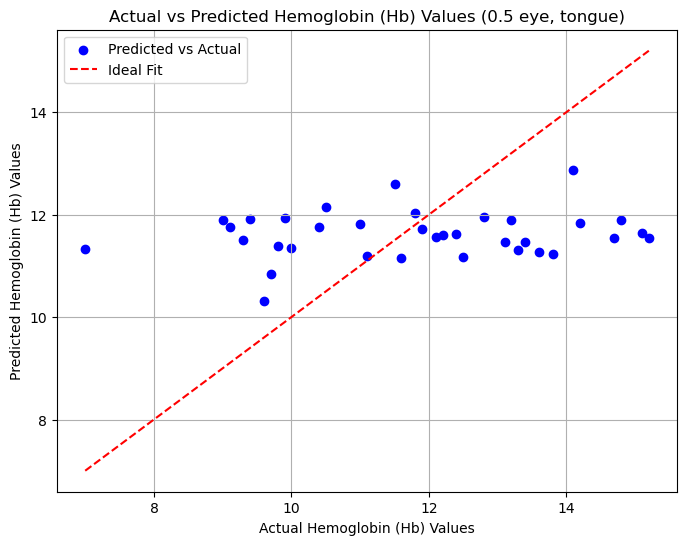

In [341]:
!pip install ultralytics
!pip install onnx2pytorch


from ultralytics import YOLO
import pandas as pd
import torch
from torchvision import transforms
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
import zipfile
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import random
import numpy as np
import torch
from torchvision import transforms
from torchvision.models import efficientnet_b0
import onnx2pytorch
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


nail_seg_model_path = '/Users/asmitha/AI_ML_Project/Segmentation/fingernail.pt'
eye_seg_model_path = '/Users/asmitha/AI_ML_Project/Segmentation/eye.pt'
tongue_seg_model_path = '/Users/asmitha/AI_ML_Project/Segmentation/tongue.pt'
palm_seg_model_path = '/Users/asmitha/AI_ML_Project/Segmentation/palm.pt'

nail_reg_model = load_model_nail('/Users/asmitha/AI_ML_Project/Regression/regression_nail.pth')
eye_reg_model = load_model_eye('/Users/asmitha/AI_ML_Project/Regression/linear_regression_eye_model.keras')
tongue_reg_model = load_model_tongue('/Users/asmitha/AI_ML_Project/Regression/regression_tongue.pth')
palm_reg_model = load_model_palm('/Users/asmitha/AI_ML_Project/Regression/regression_palm.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

excel_data = pd.read_excel('/Users/asmitha/AI_ML_Project/Anemia_dataset_train.xlsx', sheet_name=None)
base_image_dir = '/Users/asmitha/AI_ML_Project/Data'

actual_values = []
predicted_values = []
actual_accum = []
predicted_accum = []

hb_values = [7.0, 8.4, 9.9, 9.6, 11.0, 12.4, 9.7, 14.7, 
             13.1, 14.8, 15.2, 11.1, 11.8, 13.2, 13.8, 13.4, 
             15.1, 9.8, 9.0, 9.4, 9.1, 9.3, 10.5, 10.4, 10.1, 
             10.0, 10.8, 11.6, 11.5, 11.9, 12.1, 12.2, 12.5, 12.8, 
             13.6, 13.3, 14.2, 14.1, 14.0]

for value in hb_values:
    try:
        ln_path, rn_path, le_path, re_path, lp_path, rp_path, t_path = find_image_paths(value, excel_data, base_image_dir)
        print(ln_path)
        ln_input_tensor = preprocess_nail(ln_path, nail_seg_model_path)
        rn_input_tensor = preprocess_nail(rn_path, nail_seg_model_path)
        le_input_tensor = preprocess_eye(le_path, eye_seg_model_path)
        re_input_tensor = preprocess_eye(re_path, eye_seg_model_path)
        lp_input_tensor = preprocess_palm(lp_path, palm_seg_model_path)
        rp_input_tensor = preprocess_palm(rp_path, palm_seg_model_path)
        t_input_tensor = preprocess_tongue(t_path, tongue_seg_model_path)
    
        ln_input_tensor = ln_input_tensor.unsqueeze(0)
        ln_input_tensor = ln_input_tensor.to(device)
    
        rn_input_tensor = rn_input_tensor.unsqueeze(0)
        rn_input_tensor = rn_input_tensor.to(device)
    
        le_input_tensor = np.expand_dims(le_input_tensor, axis=0) 
        #le_input_tensor = preprocess_input(le_input_tensor)
        re_input_tensor = np.expand_dims(re_input_tensor, axis=0) 
        #re_input_tensor = preprocess_input(re_input_tensor)
    
        lp_input_tensor = lp_input_tensor.unsqueeze(0)
        lp_input_tensor = lp_input_tensor.to(device)
    
        rp_input_tensor = rp_input_tensor.unsqueeze(0)
        rp_input_tensor = rp_input_tensor.to(device)
    
        t_input_tensor = t_input_tensor.unsqueeze(0)
        t_input_tensor = t_input_tensor.to(device)
    
        with torch.no_grad():
            prediction1 = nail_reg_model(ln_input_tensor)
            prediction2 = nail_reg_model(rn_input_tensor)
            prediction3 = eye_reg_model.predict(le_input_tensor)/3
            prediction4 = eye_reg_model.predict(re_input_tensor)/3
            prediction5 = palm_reg_model(lp_input_tensor)
            prediction6 = palm_reg_model(rp_input_tensor)
            prediction7 = tongue_reg_model(t_input_tensor)
        
        avg_nail = (prediction1.item() + prediction2.item()) / 2
        avg_eye = (prediction3[0][0] + prediction4[0][0]) / 2
        avg_palm = (prediction5.item() + prediction6.item()) / 2
    
        weighted_avg = (0)*avg_nail + (0.5)*avg_eye + (0)*avg_palm + (0.5)*(prediction7.item())
    
        actual_values.append(value)
        predicted_values.append(weighted_avg)
    
        print(f"Actual Hemoglobin (Hb) value: {value:.4f}")
        print(f"Predicted Hemoglobin (Hb) value from Left Nail: {prediction1.item():.4f}")
        print(f"Predicted Hemoglobin (Hb) value from Right Nail: {prediction2.item():.4f}")
        print(f"Predicted Hemoglobin (Hb) value from Left Eye: {prediction3[0][0]:.4f}")
        print(f"Predicted Hemoglobin (Hb) value from Right Eye: {prediction4[0][0]:.4f}")
        print(f"Predicted Hemoglobin (Hb) value from Left Palm: {prediction5.item():.4f}")
        print(f"Predicted Hemoglobin (Hb) value from Right Palm: {prediction6.item():.4f}")
        print(f"Predicted Hemoglobin (Hb) value from Tongue: {prediction7.item():.4f}")
        print(f"Final Predicted Hemoglobin (Hb) value: {weighted_avg:.4f}")
    except Exception as e:
        print(f"Error processing Hb value {value}. Skipping to next. Error: {e}")
        continue 

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='blue', label='Predicted vs Actual')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Hemoglobin (Hb) Values')
plt.ylabel('Predicted Hemoglobin (Hb) Values')
plt.title('Actual vs Predicted Hemoglobin (Hb) Values (0.5 eye, tongue)')
plt.legend()
plt.grid(True)
plt.show()

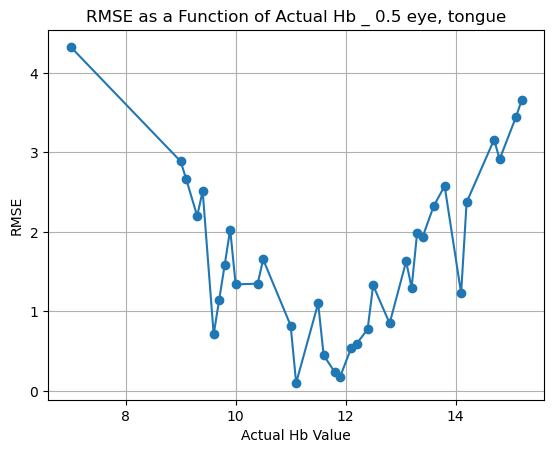

In [342]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

actual = np.array(actual_values) 
predicted = np.array(predicted_values) 
unique_hb_values = np.unique(actual)

rmse_values = []
for hb in unique_hb_values:
    indices = actual == hb 
    errors = predicted[indices] - actual[indices]
    rmse = np.sqrt(np.mean(errors ** 2))
    rmse_values.append(rmse)

plt.plot(unique_hb_values, rmse_values, marker='o')
plt.xlabel('Actual Hb Value')
plt.ylabel('RMSE')
plt.title('RMSE as a Function of Actual Hb _ 0.5 eye, tongue')
plt.grid()
plt.show()


In [343]:
actual_accum = actual_accum + actual_values
predicted_accum = predicted_accum + predicted_values

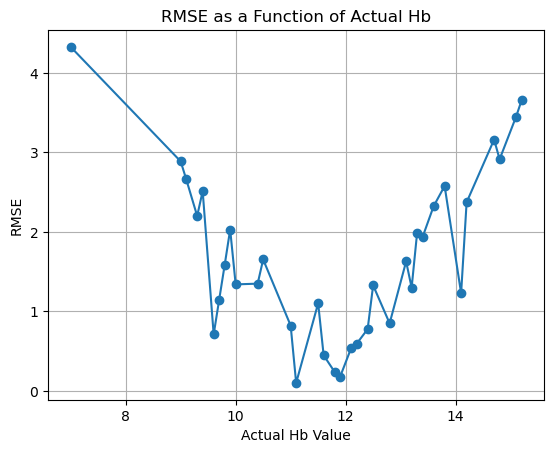

In [345]:
actual = np.array(actual_accum) 
predicted = np.array(predicted_accum) 

unique_hb_values = np.unique(actual)

rmse_values = []
for hb in unique_hb_values:
    indices = actual == hb 
    errors = predicted[indices] - actual[indices]
    rmse = np.sqrt(np.mean(errors ** 2))
    rmse_values.append(rmse)

plt.plot(unique_hb_values, rmse_values, marker='o')
plt.xlabel('Actual Hb Value')
plt.ylabel('RMSE')
plt.title('RMSE as a Function of Actual Hb')
plt.grid()
plt.show()
